### Загрузка датасета COCO и кода COCO API
Необходимо раскомментировать код ниже. В нём происходит скачивание и распаковка датасета COCO.
Кроме того, здесь клонируется репозиторий с кодом COCO API (код для работы с данными из COCO)

Запускать лучше всего в Google Cloab или на другой Linux-машине

In [1]:
!mkdir -p data

!cd data && wget http://images.cocodataset.org/zips/train2017.zip 
!cd data && wget http://images.cocodataset.org/zips/val2017.zip 
!cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 
  
!cd data && unzip -q train2017.zip
!cd data && unzip -q val2017.zip
!cd data && unzip -q annotations_trainval2017.zip

!cd data && git clone https://github.com/cocodataset/cocoapi
!cd data/cocoapi/PythonAPI && make

--2021-07-04 02:24:16--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.129.123
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.129.123|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  49.0MB/s    in 7m 20s  

2021-07-04 02:31:36 (41.9 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2021-07-04 02:31:37--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.25.164
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.25.164|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  53.2MB/s    in 14s     

2021-07-04 02:31:51 (55.8 MB/s) - 

### Импорт необходимых библиотек

In [1]:
import os
import skimage.io as io
import numpy as np

### Импорт TensorFlow

In [2]:
import tensorflow as tf
#tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.5.0


### Импорт библиотеки COCO API
Там содержатся различные функции для чтения и обработки датасета COCO

In [3]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Наш класс Dataset
Этот класс конструирует экземпляры `tf.data.Dataset` и является универсальным для сегментации (подходит для использования с различными датасетами)

Однако, это абстрактный класс, в котром не реализован метод чтения датасета с диска, так как этот метод может отличаться для разных датасетов

In [4]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.compat.v1.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Наш класс COCO_Dataset
Класс, наследованный от нашего класса `Dataset`, в котром реализован метод `read_images`, специфичный для датасета COCO

In [5]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

### Создание обучающего и вализационного датасета
Сначала создаются два экземпляра класса `COCO_Dataset`, в конструкторе которого указывается тип датасета (указание для COCO - откуда какие читать изображения)

Далее вызываются функции `train_dataset` и `val_dataset` которые создают экземпляры `tf.data.Dataset` (в первом и втором случае логика и пайплайн данных в этих датасетов отличаются)

In [6]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

train_ds = COCO_dataset_train.train_dataset(1, 5, 256)
val_ds = COCO_dataset_val.val_dataset(1, 256)

loading annotations into memory...
Done (t=28.50s)
creating index...
index created!
loading annotations into memory...
Done (t=3.97s)
creating index...
index created!


In [7]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.inp = tf.keras.layers.Input(shape=(256,256,3))
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation=None)
        self.pool = tf.keras.layers.MaxPool2D((2, 2))
        
    def call(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.pool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.pool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = tf.image.resize(out, (x.shape[1], x.shape[2]), tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out
    
model = Model()
model.build(input_shape=(None, 256, 256, 3))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36928     
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  73856     
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  147584    
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  295168    
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  2305      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0     

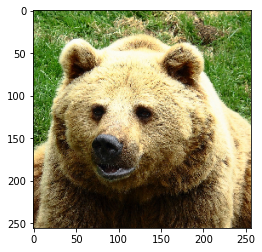

Epoch 1/5
40/40 [==============================] - 47s 1s/step - loss: 0.5679 - accuracy: 0.7142
Epoch 2/5
40/40 [==============================] - 47s 1s/step - loss: 0.5427 - accuracy: 0.7447
Epoch 3/5
40/40 [==============================] - 46s 1s/step - loss: 0.5467 - accuracy: 0.7073
Epoch 4/5
40/40 [==============================] - 46s 1s/step - loss: 0.4816 - accuracy: 0.8382
Epoch 5/5
40/40 [==============================] - 46s 1s/step - loss: 0.4866 - accuracy: 0.8038


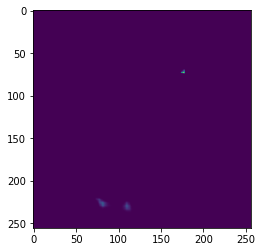

Epoch 1/5
40/40 [==============================] - 46s 1s/step - loss: 0.4832 - accuracy: 0.7991
Epoch 2/5
40/40 [==============================] - 47s 1s/step - loss: 0.4878 - accuracy: 0.7970
Epoch 3/5
40/40 [==============================] - 46s 1s/step - loss: 0.6185 - accuracy: 0.6695
Epoch 4/5
40/40 [==============================] - 46s 1s/step - loss: 0.4317 - accuracy: 0.8295
Epoch 5/5
40/40 [==============================] - 46s 1s/step - loss: 0.4463 - accuracy: 0.8123


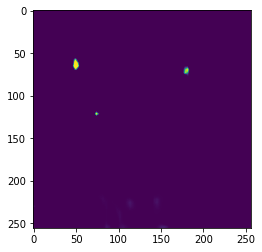

Epoch 1/5
40/40 [==============================] - 46s 1s/step - loss: 0.5552 - accuracy: 0.7472
Epoch 2/5
40/40 [==============================] - 46s 1s/step - loss: 0.4940 - accuracy: 0.7974
Epoch 3/5
40/40 [==============================] - 46s 1s/step - loss: 0.5466 - accuracy: 0.7684
Epoch 4/5
40/40 [==============================] - 47s 1s/step - loss: 0.3875 - accuracy: 0.8831
Epoch 5/5
40/40 [==============================] - 46s 1s/step - loss: 0.4549 - accuracy: 0.8166


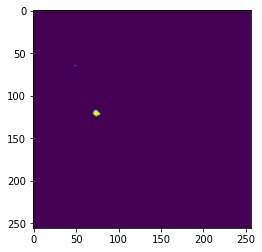

Epoch 1/5
40/40 [==============================] - 46s 1s/step - loss: 0.5502 - accuracy: 0.7588
Epoch 2/5
40/40 [==============================] - 46s 1s/step - loss: 0.5246 - accuracy: 0.7414
Epoch 3/5
40/40 [==============================] - 46s 1s/step - loss: 0.5511 - accuracy: 0.7349
Epoch 4/5
40/40 [==============================] - 46s 1s/step - loss: 0.5911 - accuracy: 0.7078
Epoch 5/5
40/40 [==============================] - 46s 1s/step - loss: 0.5472 - accuracy: 0.6895


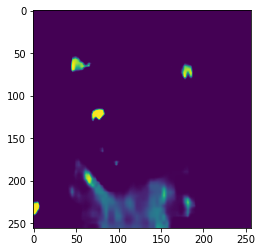

Epoch 1/5
40/40 [==============================] - 46s 1s/step - loss: 0.4425 - accuracy: 0.8196
Epoch 2/5
40/40 [==============================] - 46s 1s/step - loss: 0.4998 - accuracy: 0.7958
Epoch 3/5
40/40 [==============================] - 46s 1s/step - loss: 0.4940 - accuracy: 0.8085
Epoch 4/5
40/40 [==============================] - 46s 1s/step - loss: 0.4301 - accuracy: 0.8015
Epoch 5/5
40/40 [==============================] - 47s 1s/step - loss: 0.5542 - accuracy: 0.7240


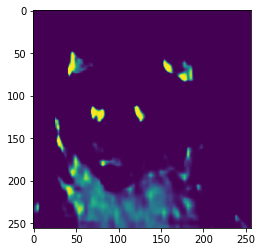

In [16]:
import keras 
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

def pred(img):
  out = model.predict(image.img_to_array(img)[None, ...])
  plt.imshow(image.array_to_img(out[0,...]))
  plt.show()

img = image.load_img("./data/val2017/000000000285.jpg", target_size=(256, 256))
plt.imshow(image.array_to_img(img))
plt.show()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

for i in range(5):
  hist = model.fit(train_ds, epochs=5,steps_per_epoch=40) 
  pred(img)